Using data from [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

# Imports

In [1]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
#import nltk
#nltk.download()

# Create train data

We turn the problem into a binary toxic/no-toxic classification, using the probability the classifier returns as a rating for how toxic the comment is.

In [191]:
df = pd.read_csv("./data/train.csv")
df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
df = df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})
df.sample(5)

,text,y
71454,Thanks for that! Now I understand.,0
30577,"""\nI take no issue with your assessment. It ac...",0
153839,"""\n\n Hi Wally, not sure if you are picking...",0
43101,Like What You Are Doing! \n\nYou have been rea...,0
103870,"""\n\nEvils of Atheism\n\nIt's about damn time ...",1


# Undersample

The dataset is very unbalanced. We will undersample the majority set.

In [3]:
df['y'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: y, dtype: float64

In [192]:
min_len = (df['y'] == 1).sum()
df_y0_undersample = df[df['y'] == 0].sample(n = min_len, random_state = 201)
df = pd.concat([df[df['y'] == 1], df_y0_undersample])
df['y'].value_counts()

1    16225
0    16225
Name: y, dtype: int64

In [207]:
df_train = df.copy()

## Feature Extraction Before Text Cleaning

The comments will ke tokenized with a TF-IDF vectorizer, which will remove some features in the original text such as punctuation. Therefore we will extract these features beforehand.

From the exploratory analysis we noticed a couple of features that may be important. These are:
- Punctuation
    - Exclamation marks are associated with emotions of anger
    - Quotation marks have been used to represent sarcasm
- Uppercase words

Toxic commenst also tend to contain misspelled words/typos, which can be achived through methods like SpellChecker, but spelling checking algorithms take too long to run and therefore will be ommitted here for now.

In [201]:
def count_punctuations(text):
    import string
    d = dict()
    for i in list(string.punctuation):
        d[str(i)+' count'] = sum([1 for char in text if char == i])
    return d

def extract_features_1(df, text):
    df['punctuation'] = text.apply(lambda x: count_punctuations(x))
    df['upper_words'] = text.apply(lambda x: len([x for x in x.split() if x.isupper()])/(len(x.split())+0.0001))
    df_punct = pd.DataFrame(list(df.punctuation))
    df.reset_index(drop=True, inplace=True)
    df_punct.reset_index(drop=True, inplace=True)
    df = pd.concat([df, df_punct], axis=1)
    df.drop(columns=['[ count','( count','{ count'], inplace=True) # The closing and opening brackets will be highly correlated, so they are removed
    df.drop(columns=['punctuation'], inplace=True)
    return df

In [153]:
df = extract_features_1(df, df['text'])

In [154]:
df.head()

,text,y,upper_words,! count,""" count",# count,$ count,% count,& count,' count,...,? count,@ count,\ count,] count,^ count,_ count,` count,| count,} count,~ count
0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hey... what is it..\n@ | talk .\nWhat is it......,1,0.113208,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
2,"Bye! \n\nDon't look, come or think of comming ...",1,0.000000,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,You are gay or antisemmitian? \n\nArchangel WH...,1,0.025641,7,0,0,0,0,0,2,...,1,0,0,0,0,0,0,0,0,0
4,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,1.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.shape[0]

32450

## Text Cleaning

In [169]:
# Define function to clean text before applyting vectorizer
def clean_text(df, text):
    # 1. Make all letters lowercase
    text = text.apply(lambda x: x.lower())
    
    # 2. Remove stop words
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    remove = ['you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves']
    for word in remove:
        stop.remove(word) # We see that a lot of toxic comments use second-person tone, so we want to retain "you" and not remove it as a stop word
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        
    # 3. Remove punctuations
    text = text.str.replace('[^\w\s]','')
    
    # 4. Remove numbers
    import re
    text = text.apply(lambda x: re.sub('([0-9]+)', '', x))
      
    # 5. Lemmatization
    from nltk.stem import WordNetLemmatizer 
    lemmatizer = WordNetLemmatizer()
    text = text.apply(lambda x: lemmatizer.lemmatize(x))
    if 'cleaned_text' in df.columns:
        df['cleaned_text'] = text
    else:
        df.insert(0, 'cleaned_text', text)
    return df

In [214]:
df = clean_text(df, df['text'])

In [171]:
df.head()

,cleaned_text,text,y,upper_words,! count,""" count",# count,$ count,% count,& count,...,? count,@ count,\ count,] count,^ count,_ count,` count,| count,} count,~ count
0,cocksucker you piss around work,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hey it talk it exclusive group wp talibansw...,Hey... what is it..\n@ | talk .\nWhat is it......,1,0.113208,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
2,bye look come think comming back tosser,"Bye! \n\nDon't look, come or think of comming ...",1,0.000000,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,you gay antisemmitian archangel white tiger me...,You are gay or antisemmitian? \n\nArchangel WH...,1,0.025641,7,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,fuck your filthy mother ass dry,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,1.000000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
df.describe()

,y,upper_words,! count,""" count",# count,$ count,% count,& count,' count,) count,...,? count,@ count,\ count,] count,^ count,_ count,` count,| count,} count,~ count
count,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,...,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000
mean,0.500000,0.085313,1.887396,1.907026,0.028598,0.009060,0.027242,0.032142,1.284191,0.410077,...,0.506687,0.016549,0.004961,0.039445,0.005639,0.111587,0.003729,0.054083,0.025424,0.040216
std,0.500008,0.206078,53.079832,6.011388,0.569372,0.348603,0.389067,0.522167,4.596509,1.893283,...,2.363791,0.791611,0.286538,0.632502,0.187268,2.791815,0.127143,0.890091,0.410952,1.365166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,4942.000000,358.000000,72.000000,42.000000,26.000000,50.000000,470.000000,164.000000,...,209.000000,128.000000,42.000000,74.000000,15.000000,288.000000,14.000000,98.000000,56.000000,238.000000


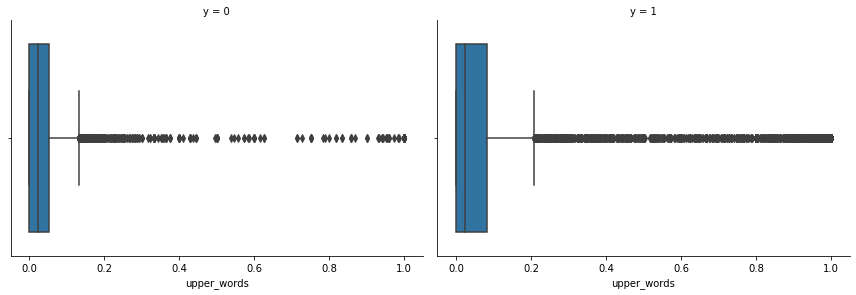

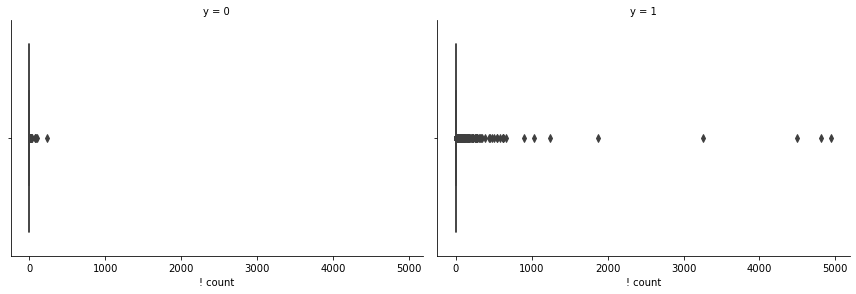

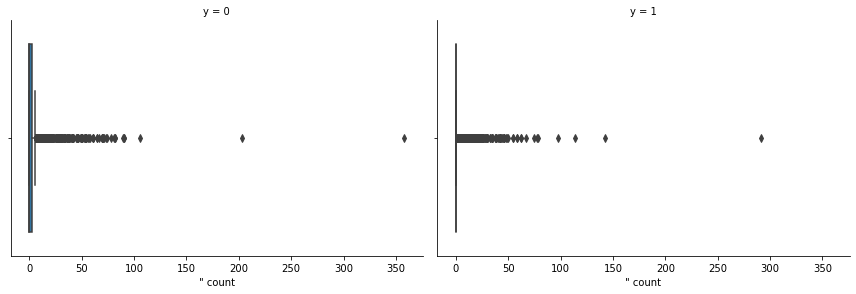

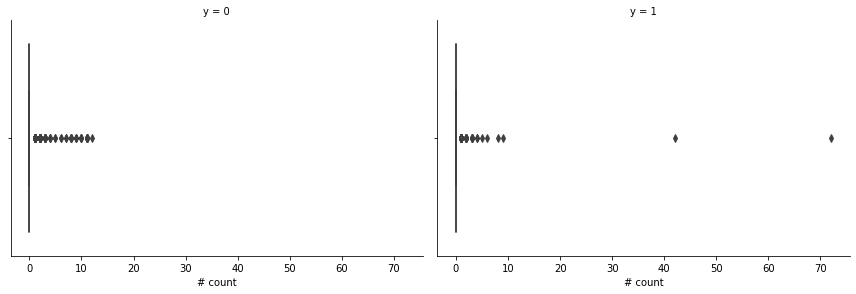

In [173]:
# Visualize the distribution of these features
    
import seaborn as sns    
for col in df.columns[3:7]:
    sns.catplot(x=col, col="y", data=df, kind="box", height=4, aspect=1.5)

As can be seen from the box plots above, all of these features are very skewed. Therefore we will aply logrithmic transformation on them.

In [174]:
import numpy as np
df[df.columns[3:]] = df[df.columns[3:]].applymap(lambda x: np.log(x+1))

In [15]:
df.shape[0]

32450

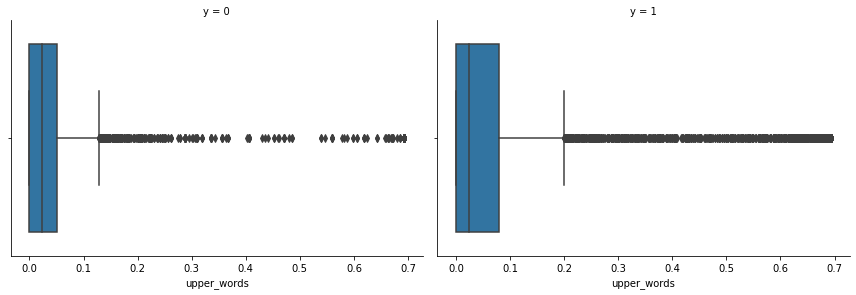

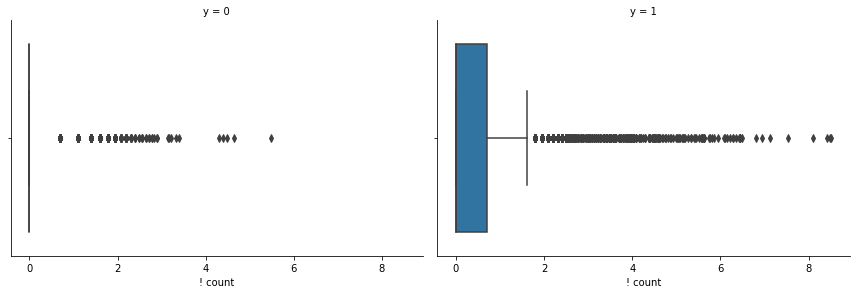

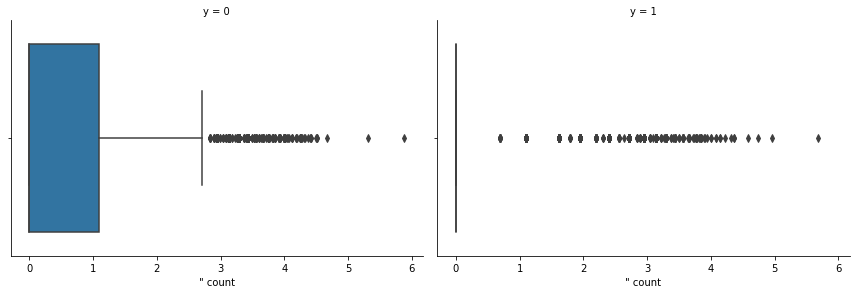

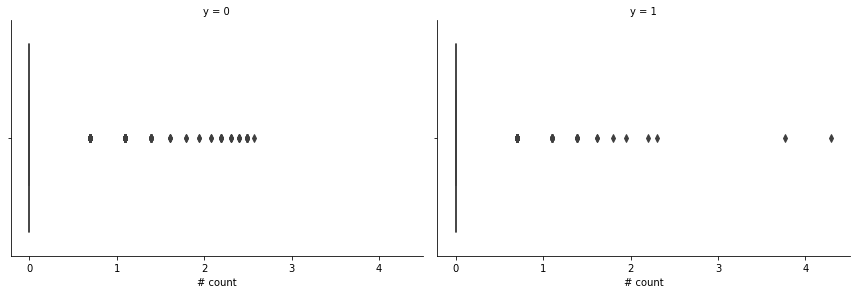

In [175]:
# Visualize again

for col in df.columns[3:7]:
    sns.catplot(x=col, col="y", data=df, kind="box", height=4, aspect=1.5)

<AxesSubplot:>

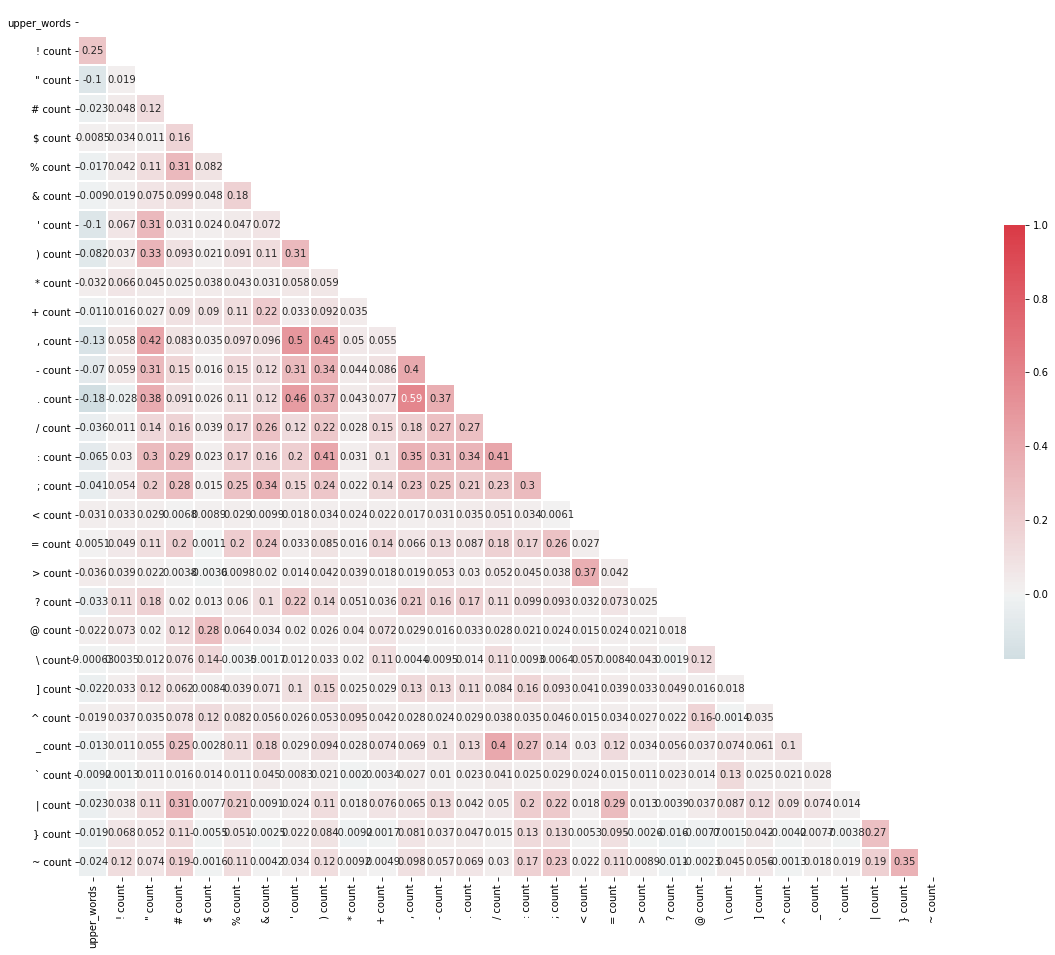

In [176]:
import matplotlib.pyplot as plt
corr  = df[df.columns[3:]].corr()
# display correlation between numeric features 

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

## TF-IDF

In [215]:
# Pre-train tf-idf vectorizer to encode the data with transform function and save it
import pickle
vectorize = TfidfVectorizer()
response = vectorize.fit_transform(df['cleaned_text'])
pickle.dump(vectorize.vocabulary_,open("feature.pkl","wb"))

In [216]:
def apply_tfidf(df, text, other_features):
    loaded_vec = TfidfVectorizer(vocabulary=pickle.load(open("feature.pkl", "rb")))
    response = loaded_vec.fit_transform(text)
    np_df = other_features.to_numpy()
    from scipy.sparse import hstack
    tfidf_features = hstack([np_df, response])
    return tfidf_features

In [187]:
features = apply_tfidf(df, df['cleaned_text'], df[df.columns[3:]])
features

C:\Users\xiche\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


<32450x72816 sparse matrix of type '<class 'numpy.float64'>'
	with 950198 stored elements in COOrdinate format>

In [217]:
# Combine all the feature extraction and preprocessing steps into one function

def text_features(df, text):
    col = df.shape[1] + 1
    df = extract_features_1(df, text)
    df[df.columns[col:]] = df[df.columns[col:]].applymap(lambda x: np.log(x+1))
    df = clean_text(df, text)
    other_features = df[df.columns[col:]]
    features = apply_tfidf(df, df['cleaned_text'], other_features)
    return features

In [223]:
X_train = text_features(df_train, df_train['text'])
X_train

<32450x1028 sparse matrix of type '<class 'numpy.float64'>'
	with 573359 stored elements in COOrdinate format>

# Fit models

In [209]:
y_train = df['y']

In [219]:
NB = MultinomialNB().fit(X_train, y_train)

In [111]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression().fit(X_train, y_train)

C:\Users\xiche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [112]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier().fit(X_train, y_train)

# Validate

In [113]:
df_val = pd.read_csv("./data/validation_data.csv")

In [220]:
# Clean validation data
less_toxic = pd.DataFrame(df_val['less_toxic'])
more_toxic = pd.DataFrame(df_val['more_toxic'])

In [221]:
X_less_toxic = text_features(less_toxic, less_toxic["less_toxic"])
X_more_toxic = text_features(more_toxic, more_toxic["more_toxic"])

In [222]:
X_less_toxic

<30108x1030 sparse matrix of type '<class 'numpy.float64'>'
	with 650450 stored elements in COOrdinate format>

We can get a validation accuracy by comparing p1 and p2. If p1 is less than p2, p1 is predicted to be less toxic than p2.

In [211]:
p1 = NB.predict_proba(X_less_toxic)
p2 = NB.predict_proba(X_more_toxic)
(p1[:, 1] < p2[:, 1]).mean()

0.6438155971834728

In [120]:
p1 = LR.predict_proba(X_less_toxic)
p2 = LR.predict_proba(X_more_toxic)
(p1[:, 1] < p2[:, 1]).mean()

0.6500929985385944

In [121]:
p1 = RF.predict_proba(X_less_toxic)
p2 = RF.predict_proba(X_more_toxic)
(p1[:, 1] < p2[:, 1]).mean()

0.6608210442407334

These validation accuracy scores are not great. In fact, they are lower than the validation scores from just the TF-IDF features without other feature extraction.

## Look for an alternative approach.